In [1]:
import torch
import copy
import random
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

from safetensors.torch import load_file
from diffusers import DiffusionPipeline

/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
torch_dtype = torch.bfloat16
device = 'cuda:0'
uce_path = '../uce_models/vangogh_flux.safetensors'

pipe = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", 
                                         torch_dtype=torch_dtype, 
                                         safety_checker=None).to(device)

uce_weights = load_file(uce_path)
original_weights = {}
for name, param in pipe.transformer.named_modules():
    if name+'.weight' in uce_weights:
        original_weights[name+'.weight'] = copy.deepcopy(param.weight)

Keyword arguments {'safety_checker': None} are not expected by FluxPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
uce_path = '../uce_models/vangogh_flux.safetensors'
uce_weights = load_file(uce_path)

# Run original model

Loaded original model weights


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Original Model')

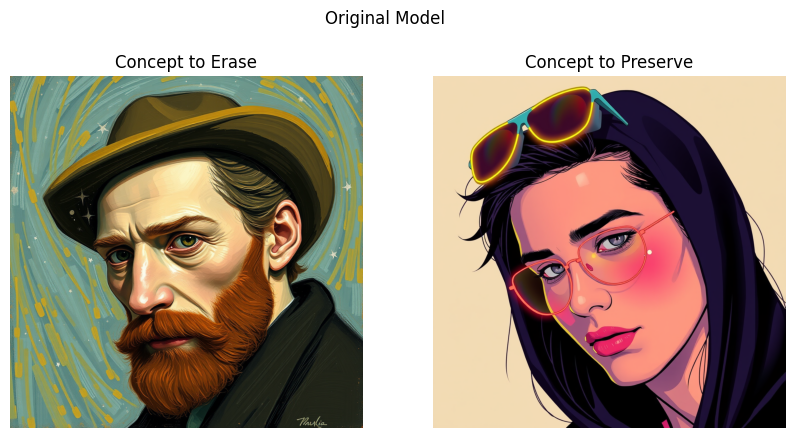

In [4]:
seed = random.randint(0, 2**15)
prompt_of_erased_concept = 'artwork of a person in the style of Van Gogh'
prompt_of_other_concept = 'artwork of a person in the style of Neon art'

# Load original model weights
pipe.transformer.load_state_dict(original_weights, strict=False)
print('Loaded original model weights')
# concept to be erased
erased_image = pipe(prompt_of_erased_concept,
                    guidance_scale = 0, 
                    num_inference_steps=4,
                    max_sequence_length=256,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]
# concept to be preserved
preserved_image = pipe(prompt_of_other_concept,
                       guidance_scale = 0, 
                       num_inference_steps=4,
                       max_sequence_length=256,
                       generator=torch.Generator().manual_seed(seed)
                      ).images[0]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(erased_image)
axs[0].axis('off')
axs[0].set_title('Concept to Erase')

axs[1].imshow(preserved_image)
axs[1].axis('off')
axs[1].set_title('Concept to Preserve')
fig.suptitle('Original Model')

# Run UCE model

Loaded UCE model weights


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0.5, 0.98, 'UCE Model')

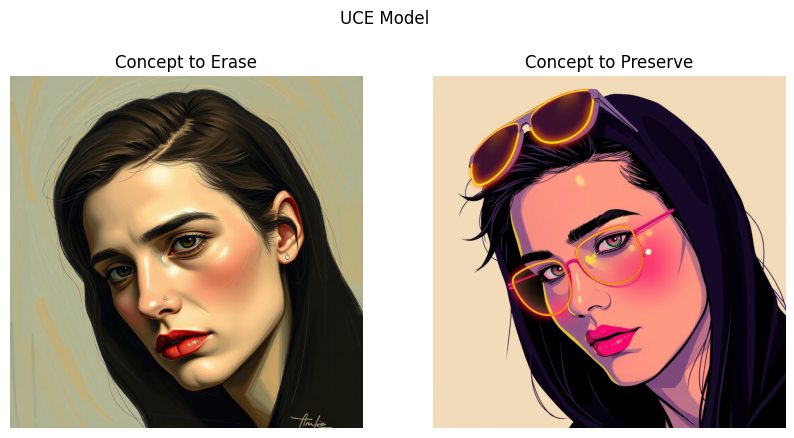

In [5]:
# Load UCE model weights
pipe.transformer.load_state_dict(uce_weights, strict=False)
print('Loaded UCE model weights')
# concept to be erased
erased_image = pipe(prompt_of_erased_concept,
                    guidance_scale = 0, 
                    num_inference_steps=4,
                    max_sequence_length=256,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]
# concept to be preserved
preserved_image = pipe(prompt_of_other_concept,
                       guidance_scale = 0, 
                       num_inference_steps=4,
                       max_sequence_length=256,
                       generator=torch.Generator().manual_seed(seed)
                      ).images[0]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(erased_image)
axs[0].axis('off')
axs[0].set_title('Concept to Erase')

axs[1].imshow(preserved_image)
axs[1].axis('off')
axs[1].set_title('Concept to Preserve')
fig.suptitle('UCE Model')